In [1]:
import torch
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
import util
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from time import time
import argparse
from datetime import date
from progressbar import *
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [3]:
def train_test_split(X, y, train_ratio=0.8):
    num_ts, num_periods, num_features = X.shape
    train_periods = int(num_periods * train_ratio)
    random.seed(2)
    Xtr = X[:, :train_periods, :]
    ytr = y[:, :train_periods]
    Xte = X[:, train_periods:, :]
    yte = y[:, train_periods:]
    return Xtr, ytr, Xte, yte


In [4]:
class Decoder(nn.Module):

    def __init__(
        self, 
        input_size, 
        output_horizon,
        encoder_hidden_size, 
        decoder_hidden_size, 
        output_size):
        super(Decoder, self).__init__()
        self.global_mlp = nn.Linear(output_horizon * (encoder_hidden_size + input_size), (output_horizon+1) * decoder_hidden_size)
        self.local_mlp = nn.Linear(decoder_hidden_size * 2 + input_size, output_size)
        self.decoder_hidden_size = decoder_hidden_size
    
    def forward(self, ht, xf):
        '''
        Args:
        ht (tensor): (1, hidden_size)
        xf (tensor): (output_horizon, num_features)
        '''
        num_ts, output_horizon, num_features = xf.size()
        num_ts, hidden_size = ht.size()
        ht = ht.unsqueeze(1)
        ht = ht.expand(num_ts, output_horizon, hidden_size)
        # inp = (xf + ht).view(batch_size, -1) # batch_size, hidden_size, output_horizon
        inp = torch.cat([xf, ht], dim=2).view(num_ts, -1)
        contexts = self.global_mlp(inp)
        contexts = contexts.view(num_ts, output_horizon+1, self.decoder_hidden_size)
        ca = contexts[:, -1, :].view(num_ts, -1)
        C = contexts[:, :-1, :]
        C = F.relu(C)
        y = []
        for i in range(output_horizon):
            ci = C[:, i, :].view(num_ts, -1)
            xfi = xf[:, i, :].view(num_ts, -1)
            inp = torch.cat([xfi, ci, ca], dim=1)
            out = self.local_mlp(inp) # num_ts, num_quantiles
            y.append(out.unsqueeze(1))
        y = torch.cat(y, dim=1) # batch_size, output_horizon, quantiles
        return y 


class MQRNN(nn.Module):

    def __init__(
        self, 
        output_horizon, 
        num_quantiles, 
        input_size, 
        embedding_size=10,
        encoder_hidden_size=64, 
        encoder_n_layers=3,
        decoder_hidden_size=64
        ):
        '''
        Args:
        output_horizon (int): output horizons to output in prediction
        num_quantiles (int): number of quantiles interests, e.g. 0.25, 0.5, 0.75
        input_size (int): feature size
        embedding_size (int): embedding size
        encoder_hidden_size (int): hidden size in encoder
        encoder_n_layers (int): encoder number of layers
        decoder_hidden_size (int): hidden size in decoder
        '''
        super(MQRNN, self).__init__()
        self.output_horizon = output_horizon
        self.encoder_hidden_size = encoder_hidden_size
        self.input_embed = nn.Linear(1, embedding_size) # time series embedding
        self.encoder = nn.LSTM(input_size + embedding_size, encoder_hidden_size, encoder_n_layers, bias=True, batch_first=True)
        self.decoder = Decoder(input_size, output_horizon, encoder_hidden_size, decoder_hidden_size, num_quantiles)
    
    def forward(self, X, y, Xf):
        '''
        Args:
        X (tensor like): shape (num_time_series, num_periods, num_features)
        y (tensor like): shape (num_time_series, num_periods)
        Xf (tensor like): shape (num_time_series, seq_len, num_features)
        '''
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            Xf = torch.from_numpy(Xf).float()
        num_ts, num_periods, num_features = X.size()
        y = y.unsqueeze(2)
        y = self.input_embed(y)
        x = torch.cat([X, y], dim=2)
        # x = x.unsqueeze(0) # batch, seq_len, embed + num_features
        _, (h, c) = self.encoder(x)
        ht = h[-1, :, :]
        # global mlp
        ht = F.relu(ht)
        ypred = self.decoder(ht, Xf)
        return ypred

    
def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int)
    seq_len (int): sequence/encoder/decoder length
    '''
    num_ts, num_periods, _ = X.shape

    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    batch = random.sample(range(num_ts), batch_size)
    
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len, :]
    yf = y[batch, t:t+seq_len]
    
    return X_train_batch, y_train_batch, Xf, yf

In [5]:
# batch_generator(X, y, num_obs_to_train, seq_len, batch_size)

In [6]:
def train(X, y, quantiles):
    num_ts, num_periods, num_features = X.shape
    num_quantiles = len(quantiles)
    model = MQRNN(seq_len, num_quantiles, num_features, embedding_size, encoder_hidden_size, n_layers, decoder_hidden_size)
    optimizer = Adam(model.parameters(), lr=lr)
    
    Xtr, ytr, Xte, yte = train_test_split(X, y)
    print("Xtr, ytr, Xte, yte:", Xtr.shape, ytr.shape, Xte.shape, yte.shape)
    
    
    losses = []
    mape_list, mae_list, rmse_list = [], [], []
    
    yscaler = None
    if standard_scaler:
        yscaler = util.StandardScaler()
    elif log_scaler:
        yscaler = util.LogScaler()
    elif mean_scaler:
        yscaler = util.MeanScaler()
    if yscaler is not None:
        ytr = yscaler.fit_transform(ytr)
    
    
    ####################  train  ####################
    progress = ProgressBar()
    for epoch in progress(range(num_epoches)):
        print("Epoch {} start...".format(epoch))
        for step in range(step_per_epoch):
            X_train_batch, y_train_batch, Xf, yf = batch_generator(Xtr, ytr, num_obs_to_train, seq_len, batch_size)

            X_train_tensor = torch.from_numpy(X_train_batch).float()
            y_train_tensor = torch.from_numpy(y_train_batch).float() 

            Xf = torch.from_numpy(Xf).float()
            yf = torch.from_numpy(yf).float()
            ypred = model(X_train_tensor, y_train_tensor, Xf)

            # quantile loss
            loss = torch.zeros_like(yf)
            num_ts = Xf.size(0)
            for q, rho in enumerate(quantiles):
                ypred_rho = ypred[:, :, q].view(num_ts, -1)
                e = ypred_rho - yf
                loss += torch.max(rho * e, (rho - 1) * e)
            loss = loss.mean()

            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    ####################  test  ####################
    for i in range(Xte.shape[1]-num_obs_to_train-seq_len):
        print('Prediction:', i)
        X_test = Xte[:, i:i+num_obs_to_train, :].reshape((num_ts, -1, num_features))
        Xf_test = Xte[:, i+num_obs_to_train:i+num_obs_to_train+seq_len, :].reshape((num_ts, -1, num_features))
        y_test = yte[:, i:i+num_obs_to_train].reshape((num_ts, -1))

        if yscaler is not None:
            y_test = yscaler.transform(y_test)
        yf_test = yte[:, i+num_obs_to_train:i+num_obs_to_train+seq_len]

        ypred = model(X_test, y_test, Xf_test) # (1, num_quantiles, output_horizon)
        ypred = ypred.data.numpy()
        ypred = yscaler.inverse_transform(ypred)

        # P50 quantile MAPE 
        mape = util.MAPE(yf_test, ypred[:, :, 1])
        mape_list.append(mape)
#         print("MAPE: {}".format(mape))

        mae = MAE(ypred[:, :, 1], yf_test)
        mae_list.append(mae)
#         print("MAE: {}".format(mae))

        rmse = np.sqrt(MSE(ypred[:, :, 1], yf_test))
        rmse_list.append(rmse)
#         print("RMSE: {}".format(rmse))
    
    return losses, mape_list, mae_list, rmse_list

In [7]:
#if args.run_test:
# data_path = util.get_data_path()
dataset = pd.read_csv("../../../data/TFT_energy.csv")
dataset.fillna(0, inplace=True)
dataset = dataset[:35060]
print(dataset.shape)
# dataset

(35060, 27)


In [8]:
dataset

,time,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
0,2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
1,2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2,2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
3,2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
4,2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35055,2018-12-31 15:00:00+00:00,71.36,64.80,2503.0,6379.0,26449.0,0.0,178.0,96.0,1027.0,...,0.0,0.0,1048.0,50.0,3.0,3.0,0.0,2267.0,1.0,323.0
35056,2018-12-31 16:00:00+00:00,75.13,68.01,2583.0,6892.0,26738.0,0.0,177.0,95.0,1027.0,...,0.0,0.0,1088.0,50.0,3.0,3.0,1.0,2550.0,1.0,124.0
35057,2018-12-31 17:00:00+00:00,77.61,68.58,2604.0,7593.0,29592.0,0.0,178.0,92.0,1027.0,...,0.0,0.0,1131.0,60.0,3.0,3.0,1.0,2952.0,1.0,1.0
35058,2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0


In [9]:
dataset['date'] = pd.to_datetime(dataset['time'])
# dataset

In [10]:
dataset['Day of Week'] = dataset['date'].dt.dayofweek
dataset['day'] = dataset['date'].dt.day
dataset['hour'] = dataset['date'].dt.hour
dataset['month'] = dataset['date'].dt.month
dataset = dataset.drop(['date'], axis=1)
dataset

,time,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,...,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump,Day of Week,day,hour,month
0,2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,...,7.0,1.0,0.0,5890.0,1.0,920.0,3,1,0,1
1,2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,...,7.0,0.0,1.0,5461.0,1.0,1164.0,3,1,1,1
2,2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,...,7.0,0.0,1.0,5238.0,1.0,1503.0,3,1,2,1
3,2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,...,7.0,0.0,1.0,4935.0,1.0,1826.0,3,1,3,1
4,2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,...,5.0,2.0,1.0,4618.0,0.0,2109.0,3,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35055,2018-12-31 15:00:00+00:00,71.36,64.80,2503.0,6379.0,26449.0,0.0,178.0,96.0,1027.0,...,3.0,3.0,0.0,2267.0,1.0,323.0,0,31,15,12
35056,2018-12-31 16:00:00+00:00,75.13,68.01,2583.0,6892.0,26738.0,0.0,177.0,95.0,1027.0,...,3.0,3.0,1.0,2550.0,1.0,124.0,0,31,16,12
35057,2018-12-31 17:00:00+00:00,77.61,68.58,2604.0,7593.0,29592.0,0.0,178.0,92.0,1027.0,...,3.0,3.0,1.0,2952.0,1.0,1.0,0,31,17,12
35058,2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,...,1.0,2.0,0.0,3113.0,1.0,1.0,0,31,18,12


In [11]:
dataset.columns

Index(['time', 'price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump',
       'Day of Week', 'day', 'hour', 'month'],
      dtype='object')

In [12]:
num_epoches = 1000    # 35040
step_per_epoch = 3
lr = 1e-3
batch_size = 256
n_layers = 3
encoder_hidden_size = 64
decoder_hidden_size = 64
seq_len = 24
num_obs_to_train = 24*3
embedding_size = 24
standard_scaler = True

X.shape, y.shape: (10, 3506, 29) (10, 3506)
Xtr, ytr, Xte, yte: (10, 2804, 29) (10, 2804) (10, 702, 29) (10, 702)
Epoch 0 start...
Epoch 1 start...
Epoch 2 start...
Epoch 3 start...
Epoch 4 start...
Epoch 5 start...
Epoch 6 start...
Epoch 7 start...


Epoch 8 start...
Epoch 9 start...
Epoch 10 start...
Epoch 11 start...
Epoch 12 start...
Epoch 13 start...
Epoch 14 start...
Epoch 15 start...


Epoch 16 start...
Epoch 17 start...
Epoch 18 start...
Epoch 19 start...
Epoch 20 start...
Epoch 21 start...
Epoch 22 start...
Epoch 23 start...


Epoch 24 start...
Epoch 25 start...
Epoch 26 start...
Epoch 27 start...
Epoch 28 start...
Epoch 29 start...
Epoch 30 start...
Epoch 31 start...


Epoch 32 start...
Epoch 33 start...
Epoch 34 start...
Epoch 35 start...
Epoch 36 start...
Epoch 37 start...
Epoch 38 start...
Epoch 39 start...


Epoch 40 start...
Epoch 41 start...
Epoch 42 start...
Epoch 43 start...
Epoch 44 start...
Epoch 45 start...
Epoch 46 start...
Epoch 47 start...


Epoch 48 start...
Epoch 49 start...
Epoch 50 start...
Epoch 51 start...
Epoch 52 start...
Epoch 53 start...
Epoch 54 start...
Epoch 55 start...


Epoch 56 start...
Epoch 57 start...
Epoch 58 start...
Epoch 59 start...
Epoch 60 start...
Epoch 61 start...
Epoch 62 start...
Epoch 63 start...


Epoch 64 start...
Epoch 65 start...
Epoch 66 start...
Epoch 67 start...
Epoch 68 start...
Epoch 69 start...
Epoch 70 start...
Epoch 71 start...


Epoch 72 start...
Epoch 73 start...
Epoch 74 start...
Epoch 75 start...
Epoch 76 start...
Epoch 77 start...
Epoch 78 start...
Epoch 79 start...


Epoch 80 start...
Epoch 81 start...
Epoch 82 start...
Epoch 83 start...
Epoch 84 start...
Epoch 85 start...
Epoch 86 start...
Epoch 87 start...


Epoch 88 start...
Epoch 89 start...
Epoch 90 start...
Epoch 91 start...
Epoch 92 start...
Epoch 93 start...
Epoch 94 start...
Epoch 95 start...


Epoch 96 start...
Epoch 97 start...
Epoch 98 start...
Epoch 99 start...
Epoch 100 start...
Epoch 101 start...
Epoch 102 start...
Epoch 103 start...


Epoch 104 start...
Epoch 105 start...
Epoch 106 start...
Epoch 107 start...
Epoch 108 start...
Epoch 109 start...
Epoch 110 start...
Epoch 111 start...


Epoch 112 start...
Epoch 113 start...
Epoch 114 start...
Epoch 115 start...
Epoch 116 start...
Epoch 117 start...
Epoch 118 start...
Epoch 119 start...


Epoch 120 start...
Epoch 121 start...
Epoch 122 start...
Epoch 123 start...
Epoch 124 start...
Epoch 125 start...
Epoch 126 start...
Epoch 127 start...


Epoch 128 start...
Epoch 129 start...
Epoch 130 start...
Epoch 131 start...
Epoch 132 start...
Epoch 133 start...
Epoch 134 start...
Epoch 135 start...


Epoch 136 start...
Epoch 137 start...
Epoch 138 start...
Epoch 139 start...
Epoch 140 start...
Epoch 141 start...
Epoch 142 start...
Epoch 143 start...


Epoch 144 start...
Epoch 145 start...
Epoch 146 start...
Epoch 147 start...
Epoch 148 start...
Epoch 149 start...
Epoch 150 start...
Epoch 151 start...


Epoch 152 start...
Epoch 153 start...
Epoch 154 start...
Epoch 155 start...
Epoch 156 start...
Epoch 157 start...
Epoch 158 start...
Epoch 159 start...


Epoch 160 start...
Epoch 161 start...
Epoch 162 start...
Epoch 163 start...
Epoch 164 start...
Epoch 165 start...
Epoch 166 start...
Epoch 167 start...


Epoch 168 start...
Epoch 169 start...
Epoch 170 start...
Epoch 171 start...
Epoch 172 start...
Epoch 173 start...
Epoch 174 start...
Epoch 175 start...


Epoch 176 start...
Epoch 177 start...
Epoch 178 start...
Epoch 179 start...
Epoch 180 start...
Epoch 181 start...
Epoch 182 start...
Epoch 183 start...


Epoch 184 start...
Epoch 185 start...
Epoch 186 start...
Epoch 187 start...
Epoch 188 start...
Epoch 189 start...
Epoch 190 start...
Epoch 191 start...


Epoch 192 start...
Epoch 193 start...
Epoch 194 start...
Epoch 195 start...
Epoch 196 start...
Epoch 197 start...
Epoch 198 start...
Epoch 199 start...


Epoch 200 start...
Epoch 201 start...
Epoch 202 start...
Epoch 203 start...
Epoch 204 start...
Epoch 205 start...
Epoch 206 start...
Epoch 207 start...


Epoch 208 start...
Epoch 209 start...
Epoch 210 start...
Epoch 211 start...
Epoch 212 start...
Epoch 213 start...
Epoch 214 start...
Epoch 215 start...


Epoch 216 start...
Epoch 217 start...
Epoch 218 start...
Epoch 219 start...
Epoch 220 start...
Epoch 221 start...
Epoch 222 start...
Epoch 223 start...


Epoch 224 start...
Epoch 225 start...
Epoch 226 start...
Epoch 227 start...
Epoch 228 start...
Epoch 229 start...
Epoch 230 start...
Epoch 231 start...


Epoch 232 start...
Epoch 233 start...
Epoch 234 start...
Epoch 235 start...
Epoch 236 start...
Epoch 237 start...
Epoch 238 start...
Epoch 239 start...


Epoch 240 start...
Epoch 241 start...
Epoch 242 start...
Epoch 243 start...
Epoch 244 start...
Epoch 245 start...
Epoch 246 start...
Epoch 247 start...


Epoch 248 start...
Epoch 249 start...
Epoch 250 start...
Epoch 251 start...
Epoch 252 start...
Epoch 253 start...
Epoch 254 start...
Epoch 255 start...


Epoch 256 start...
Epoch 257 start...
Epoch 258 start...
Epoch 259 start...
Epoch 260 start...
Epoch 261 start...
Epoch 262 start...
Epoch 263 start...


Epoch 264 start...
Epoch 265 start...
Epoch 266 start...
Epoch 267 start...
Epoch 268 start...
Epoch 269 start...
Epoch 270 start...
Epoch 271 start...


Epoch 272 start...
Epoch 273 start...
Epoch 274 start...
Epoch 275 start...
Epoch 276 start...
Epoch 277 start...
Epoch 278 start...
Epoch 279 start...


Epoch 280 start...
Epoch 281 start...
Epoch 282 start...
Epoch 283 start...
Epoch 284 start...
Epoch 285 start...
Epoch 286 start...
Epoch 287 start...


Epoch 288 start...
Epoch 289 start...
Epoch 290 start...
Epoch 291 start...
Epoch 292 start...
Epoch 293 start...
Epoch 294 start...
Epoch 295 start...


Epoch 296 start...
Epoch 297 start...
Epoch 298 start...
Epoch 299 start...
Epoch 300 start...
Epoch 301 start...
Epoch 302 start...
Epoch 303 start...


Epoch 304 start...
Epoch 305 start...
Epoch 306 start...
Epoch 307 start...
Epoch 308 start...
Epoch 309 start...
Epoch 310 start...
Epoch 311 start...


Epoch 312 start...
Epoch 313 start...
Epoch 314 start...
Epoch 315 start...
Epoch 316 start...
Epoch 317 start...
Epoch 318 start...
Epoch 319 start...


Epoch 320 start...
Epoch 321 start...
Epoch 322 start...
Epoch 323 start...
Epoch 324 start...
Epoch 325 start...
Epoch 326 start...
Epoch 327 start...


Epoch 328 start...
Epoch 329 start...
Epoch 330 start...
Epoch 331 start...
Epoch 332 start...
Epoch 333 start...
Epoch 334 start...
Epoch 335 start...


Epoch 336 start...
Epoch 337 start...
Epoch 338 start...
Epoch 339 start...
Epoch 340 start...
Epoch 341 start...
Epoch 342 start...
Epoch 343 start...


Epoch 344 start...
Epoch 345 start...
Epoch 346 start...
Epoch 347 start...
Epoch 348 start...
Epoch 349 start...
Epoch 350 start...
Epoch 351 start...


Epoch 352 start...
Epoch 353 start...
Epoch 354 start...
Epoch 355 start...
Epoch 356 start...
Epoch 357 start...
Epoch 358 start...
Epoch 359 start...


Epoch 360 start...
Epoch 361 start...
Epoch 362 start...
Epoch 363 start...
Epoch 364 start...
Epoch 365 start...
Epoch 366 start...
Epoch 367 start...


Epoch 368 start...
Epoch 369 start...
Epoch 370 start...
Epoch 371 start...
Epoch 372 start...
Epoch 373 start...
Epoch 374 start...
Epoch 375 start...


Epoch 376 start...
Epoch 377 start...
Epoch 378 start...
Epoch 379 start...
Epoch 380 start...
Epoch 381 start...
Epoch 382 start...
Epoch 383 start...


Epoch 384 start...
Epoch 385 start...
Epoch 386 start...
Epoch 387 start...
Epoch 388 start...
Epoch 389 start...
Epoch 390 start...
Epoch 391 start...


Epoch 392 start...
Epoch 393 start...
Epoch 394 start...
Epoch 395 start...
Epoch 396 start...
Epoch 397 start...
Epoch 398 start...
Epoch 399 start...


Epoch 400 start...
Epoch 401 start...
Epoch 402 start...
Epoch 403 start...
Epoch 404 start...
Epoch 405 start...
Epoch 406 start...
Epoch 407 start...


Epoch 408 start...
Epoch 409 start...
Epoch 410 start...
Epoch 411 start...
Epoch 412 start...
Epoch 413 start...
Epoch 414 start...
Epoch 415 start...


Epoch 416 start...
Epoch 417 start...
Epoch 418 start...
Epoch 419 start...
Epoch 420 start...
Epoch 421 start...
Epoch 422 start...
Epoch 423 start...


Epoch 424 start...
Epoch 425 start...
Epoch 426 start...
Epoch 427 start...
Epoch 428 start...
Epoch 429 start...
Epoch 430 start...
Epoch 431 start...


Epoch 432 start...
Epoch 433 start...
Epoch 434 start...
Epoch 435 start...
Epoch 436 start...
Epoch 437 start...
Epoch 438 start...
Epoch 439 start...


Epoch 440 start...
Epoch 441 start...
Epoch 442 start...
Epoch 443 start...
Epoch 444 start...
Epoch 445 start...
Epoch 446 start...
Epoch 447 start...


Epoch 448 start...
Epoch 449 start...
Epoch 450 start...
Epoch 451 start...
Epoch 452 start...
Epoch 453 start...
Epoch 454 start...
Epoch 455 start...


Epoch 456 start...
Epoch 457 start...
Epoch 458 start...
Epoch 459 start...
Epoch 460 start...
Epoch 461 start...
Epoch 462 start...
Epoch 463 start...


Epoch 464 start...
Epoch 465 start...
Epoch 466 start...
Epoch 467 start...
Epoch 468 start...
Epoch 469 start...
Epoch 470 start...
Epoch 471 start...


Epoch 472 start...
Epoch 473 start...
Epoch 474 start...
Epoch 475 start...
Epoch 476 start...
Epoch 477 start...
Epoch 478 start...
Epoch 479 start...


Epoch 480 start...
Epoch 481 start...
Epoch 482 start...
Epoch 483 start...
Epoch 484 start...
Epoch 485 start...
Epoch 486 start...
Epoch 487 start...


Epoch 488 start...
Epoch 489 start...
Epoch 490 start...
Epoch 491 start...
Epoch 492 start...
Epoch 493 start...
Epoch 494 start...
Epoch 495 start...


Epoch 496 start...
Epoch 497 start...
Epoch 498 start...
Epoch 499 start...
Epoch 500 start...
Epoch 501 start...
Epoch 502 start...
Epoch 503 start...


Epoch 504 start...
Epoch 505 start...
Epoch 506 start...
Epoch 507 start...
Epoch 508 start...
Epoch 509 start...
Epoch 510 start...
Epoch 511 start...


Epoch 512 start...
Epoch 513 start...
Epoch 514 start...
Epoch 515 start...
Epoch 516 start...
Epoch 517 start...
Epoch 518 start...
Epoch 519 start...


Epoch 520 start...
Epoch 521 start...
Epoch 522 start...
Epoch 523 start...
Epoch 524 start...
Epoch 525 start...
Epoch 526 start...
Epoch 527 start...


Epoch 528 start...
Epoch 529 start...
Epoch 530 start...
Epoch 531 start...
Epoch 532 start...
Epoch 533 start...
Epoch 534 start...
Epoch 535 start...


Epoch 536 start...
Epoch 537 start...
Epoch 538 start...
Epoch 539 start...
Epoch 540 start...
Epoch 541 start...
Epoch 542 start...
Epoch 543 start...


Epoch 544 start...
Epoch 545 start...
Epoch 546 start...
Epoch 547 start...
Epoch 548 start...
Epoch 549 start...
Epoch 550 start...
Epoch 551 start...


Epoch 552 start...
Epoch 553 start...
Epoch 554 start...
Epoch 555 start...
Epoch 556 start...
Epoch 557 start...
Epoch 558 start...
Epoch 559 start...


Epoch 560 start...
Epoch 561 start...
Epoch 562 start...
Epoch 563 start...
Epoch 564 start...
Epoch 565 start...
Epoch 566 start...
Epoch 567 start...


Epoch 568 start...
Epoch 569 start...
Epoch 570 start...
Epoch 571 start...
Epoch 572 start...
Epoch 573 start...
Epoch 574 start...
Epoch 575 start...


Epoch 576 start...
Epoch 577 start...
Epoch 578 start...
Epoch 579 start...
Epoch 580 start...
Epoch 581 start...
Epoch 582 start...
Epoch 583 start...


Epoch 584 start...
Epoch 585 start...
Epoch 586 start...
Epoch 587 start...
Epoch 588 start...
Epoch 589 start...
Epoch 590 start...
Epoch 591 start...


Epoch 592 start...
Epoch 593 start...
Epoch 594 start...
Epoch 595 start...
Epoch 596 start...
Epoch 597 start...
Epoch 598 start...
Epoch 599 start...


Epoch 600 start...
Epoch 601 start...
Epoch 602 start...
Epoch 603 start...
Epoch 604 start...
Epoch 605 start...
Epoch 606 start...
Epoch 607 start...


Epoch 608 start...
Epoch 609 start...
Epoch 610 start...
Epoch 611 start...
Epoch 612 start...
Epoch 613 start...
Epoch 614 start...
Epoch 615 start...


Epoch 616 start...
Epoch 617 start...
Epoch 618 start...
Epoch 619 start...
Epoch 620 start...
Epoch 621 start...
Epoch 622 start...
Epoch 623 start...


Epoch 624 start...
Epoch 625 start...
Epoch 626 start...
Epoch 627 start...
Epoch 628 start...
Epoch 629 start...
Epoch 630 start...
Epoch 631 start...


Epoch 632 start...
Epoch 633 start...
Epoch 634 start...
Epoch 635 start...
Epoch 636 start...
Epoch 637 start...
Epoch 638 start...
Epoch 639 start...


Epoch 640 start...
Epoch 641 start...
Epoch 642 start...
Epoch 643 start...
Epoch 644 start...
Epoch 645 start...
Epoch 646 start...
Epoch 647 start...


Epoch 648 start...
Epoch 649 start...
Epoch 650 start...
Epoch 651 start...
Epoch 652 start...
Epoch 653 start...
Epoch 654 start...
Epoch 655 start...


Epoch 656 start...
Epoch 657 start...
Epoch 658 start...
Epoch 659 start...
Epoch 660 start...
Epoch 661 start...
Epoch 662 start...
Epoch 663 start...


Epoch 664 start...
Epoch 665 start...
Epoch 666 start...
Epoch 667 start...
Epoch 668 start...
Epoch 669 start...
Epoch 670 start...
Epoch 671 start...


Epoch 672 start...
Epoch 673 start...
Epoch 674 start...
Epoch 675 start...
Epoch 676 start...
Epoch 677 start...
Epoch 678 start...
Epoch 679 start...


Epoch 680 start...
Epoch 681 start...
Epoch 682 start...
Epoch 683 start...
Epoch 684 start...
Epoch 685 start...
Epoch 686 start...
Epoch 687 start...


Epoch 688 start...
Epoch 689 start...
Epoch 690 start...
Epoch 691 start...
Epoch 692 start...
Epoch 693 start...
Epoch 694 start...
Epoch 695 start...


Epoch 696 start...
Epoch 697 start...
Epoch 698 start...
Epoch 699 start...
Epoch 700 start...
Epoch 701 start...
Epoch 702 start...
Epoch 703 start...


Epoch 704 start...
Epoch 705 start...
Epoch 706 start...
Epoch 707 start...
Epoch 708 start...
Epoch 709 start...
Epoch 710 start...
Epoch 711 start...


Epoch 712 start...
Epoch 713 start...
Epoch 714 start...
Epoch 715 start...
Epoch 716 start...
Epoch 717 start...
Epoch 718 start...
Epoch 719 start...


Epoch 720 start...
Epoch 721 start...
Epoch 722 start...
Epoch 723 start...
Epoch 724 start...
Epoch 725 start...
Epoch 726 start...
Epoch 727 start...


Epoch 728 start...
Epoch 729 start...
Epoch 730 start...
Epoch 731 start...
Epoch 732 start...
Epoch 733 start...
Epoch 734 start...
Epoch 735 start...


Epoch 736 start...
Epoch 737 start...
Epoch 738 start...
Epoch 739 start...
Epoch 740 start...
Epoch 741 start...
Epoch 742 start...
Epoch 743 start...


Epoch 744 start...
Epoch 745 start...
Epoch 746 start...
Epoch 747 start...
Epoch 748 start...
Epoch 749 start...
Epoch 750 start...
Epoch 751 start...


Epoch 752 start...
Epoch 753 start...
Epoch 754 start...
Epoch 755 start...
Epoch 756 start...
Epoch 757 start...
Epoch 758 start...
Epoch 759 start...


Epoch 760 start...
Epoch 761 start...
Epoch 762 start...
Epoch 763 start...
Epoch 764 start...
Epoch 765 start...
Epoch 766 start...
Epoch 767 start...


Epoch 768 start...
Epoch 769 start...
Epoch 770 start...
Epoch 771 start...
Epoch 772 start...
Epoch 773 start...
Epoch 774 start...
Epoch 775 start...


Epoch 776 start...
Epoch 777 start...
Epoch 778 start...
Epoch 779 start...
Epoch 780 start...
Epoch 781 start...
Epoch 782 start...
Epoch 783 start...


Epoch 784 start...
Epoch 785 start...
Epoch 786 start...
Epoch 787 start...
Epoch 788 start...
Epoch 789 start...
Epoch 790 start...
Epoch 791 start...


Epoch 792 start...
Epoch 793 start...
Epoch 794 start...
Epoch 795 start...
Epoch 796 start...
Epoch 797 start...
Epoch 798 start...
Epoch 799 start...


Epoch 800 start...
Epoch 801 start...
Epoch 802 start...
Epoch 803 start...
Epoch 804 start...
Epoch 805 start...
Epoch 806 start...
Epoch 807 start...


Epoch 808 start...
Epoch 809 start...
Epoch 810 start...
Epoch 811 start...
Epoch 812 start...
Epoch 813 start...
Epoch 814 start...
Epoch 815 start...


Epoch 816 start...
Epoch 817 start...
Epoch 818 start...
Epoch 819 start...
Epoch 820 start...
Epoch 821 start...
Epoch 822 start...
Epoch 823 start...


Epoch 824 start...
Epoch 825 start...
Epoch 826 start...
Epoch 827 start...
Epoch 828 start...
Epoch 829 start...
Epoch 830 start...
Epoch 831 start...


Epoch 832 start...
Epoch 833 start...
Epoch 834 start...
Epoch 835 start...
Epoch 836 start...
Epoch 837 start...
Epoch 838 start...
Epoch 839 start...


Epoch 840 start...
Epoch 841 start...
Epoch 842 start...
Epoch 843 start...
Epoch 844 start...
Epoch 845 start...
Epoch 846 start...
Epoch 847 start...


Epoch 848 start...
Epoch 849 start...
Epoch 850 start...
Epoch 851 start...
Epoch 852 start...
Epoch 853 start...
Epoch 854 start...
Epoch 855 start...


Epoch 856 start...
Epoch 857 start...
Epoch 858 start...
Epoch 859 start...
Epoch 860 start...
Epoch 861 start...
Epoch 862 start...
Epoch 863 start...


Epoch 864 start...
Epoch 865 start...
Epoch 866 start...
Epoch 867 start...
Epoch 868 start...
Epoch 869 start...
Epoch 870 start...
Epoch 871 start...


Epoch 872 start...
Epoch 873 start...
Epoch 874 start...
Epoch 875 start...
Epoch 876 start...
Epoch 877 start...
Epoch 878 start...
Epoch 879 start...


Epoch 880 start...
Epoch 881 start...
Epoch 882 start...
Epoch 883 start...
Epoch 884 start...
Epoch 885 start...
Epoch 886 start...
Epoch 887 start...


Epoch 888 start...
Epoch 889 start...
Epoch 890 start...
Epoch 891 start...
Epoch 892 start...
Epoch 893 start...
Epoch 894 start...
Epoch 895 start...


Epoch 896 start...
Epoch 897 start...
Epoch 898 start...
Epoch 899 start...
Epoch 900 start...
Epoch 901 start...
Epoch 902 start...
Epoch 903 start...


Epoch 904 start...
Epoch 905 start...
Epoch 906 start...
Epoch 907 start...
Epoch 908 start...
Epoch 909 start...
Epoch 910 start...
Epoch 911 start...


Epoch 912 start...
Epoch 913 start...
Epoch 914 start...
Epoch 915 start...
Epoch 916 start...
Epoch 917 start...
Epoch 918 start...
Epoch 919 start...


Epoch 920 start...
Epoch 921 start...
Epoch 922 start...
Epoch 923 start...
Epoch 924 start...
Epoch 925 start...
Epoch 926 start...
Epoch 927 start...


Epoch 928 start...
Epoch 929 start...
Epoch 930 start...
Epoch 931 start...
Epoch 932 start...
Epoch 933 start...
Epoch 934 start...
Epoch 935 start...


Epoch 936 start...
Epoch 937 start...
Epoch 938 start...
Epoch 939 start...
Epoch 940 start...
Epoch 941 start...
Epoch 942 start...
Epoch 943 start...


Epoch 944 start...
Epoch 945 start...
Epoch 946 start...
Epoch 947 start...
Epoch 948 start...
Epoch 949 start...
Epoch 950 start...
Epoch 951 start...


Epoch 952 start...
Epoch 953 start...
Epoch 954 start...
Epoch 955 start...
Epoch 956 start...
Epoch 957 start...
Epoch 958 start...
Epoch 959 start...


Epoch 960 start...
Epoch 961 start...
Epoch 962 start...
Epoch 963 start...
Epoch 964 start...
Epoch 965 start...
Epoch 966 start...
Epoch 967 start...


Epoch 968 start...
Epoch 969 start...
Epoch 970 start...
Epoch 971 start...
Epoch 972 start...
Epoch 973 start...
Epoch 974 start...
Epoch 975 start...


Epoch 976 start...
Epoch 977 start...
Epoch 978 start...
Epoch 979 start...
Epoch 980 start...
Epoch 981 start...
Epoch 982 start...
Epoch 983 start...


Epoch 984 start...
Epoch 985 start...
Epoch 986 start...
Epoch 987 start...
Epoch 988 start...
Epoch 989 start...
Epoch 990 start...
Epoch 991 start...


Epoch 992 start...
Epoch 993 start...
Epoch 994 start...
Epoch 995 start...
Epoch 996 start...
Epoch 997 start...
Epoch 998 start...
Epoch 999 start...


100% |##########################################################################################################################|


Prediction: 0
Prediction: 1
Prediction: 2
Prediction: 3
Prediction: 4
Prediction: 5
Prediction: 6
Prediction: 7
Prediction: 8
Prediction: 9
Prediction: 10
Prediction: 11
Prediction: 12
Prediction: 13
Prediction: 14
Prediction: 15
Prediction: 16
Prediction: 17
Prediction: 18
Prediction: 19
Prediction: 20
Prediction: 21
Prediction: 22
Prediction: 23
Prediction: 24
Prediction: 25
Prediction: 26
Prediction: 27
Prediction: 28
Prediction: 29
Prediction: 30
Prediction: 31
Prediction: 32
Prediction: 33
Prediction: 34
Prediction: 35
Prediction: 36
Prediction: 37
Prediction: 38
Prediction: 39
Prediction: 40
Prediction: 41
Prediction: 42
Prediction: 43
Prediction: 44
Prediction: 45
Prediction: 46
Prediction: 47
Prediction: 48
Prediction: 49
Prediction: 50
Prediction: 51
Prediction: 52
Prediction: 53
Prediction: 54
Prediction: 55
Prediction: 56
Prediction: 57
Prediction: 58
Prediction: 59
Prediction: 60
Prediction: 61
Prediction: 62
Prediction: 63
Prediction: 64
Prediction: 65
Prediction: 66
Predi

Prediction: 526
Prediction: 527
Prediction: 528
Prediction: 529
Prediction: 530
Prediction: 531
Prediction: 532
Prediction: 533
Prediction: 534
Prediction: 535
Prediction: 536
Prediction: 537
Prediction: 538
Prediction: 539
Prediction: 540
Prediction: 541
Prediction: 542
Prediction: 543
Prediction: 544
Prediction: 545
Prediction: 546
Prediction: 547
Prediction: 548
Prediction: 549
Prediction: 550
Prediction: 551
Prediction: 552
Prediction: 553
Prediction: 554
Prediction: 555
Prediction: 556
Prediction: 557
Prediction: 558
Prediction: 559
Prediction: 560
Prediction: 561
Prediction: 562
Prediction: 563
Prediction: 564
Prediction: 565
Prediction: 566
Prediction: 567
Prediction: 568
Prediction: 569
Prediction: 570
Prediction: 571
Prediction: 572
Prediction: 573
Prediction: 574
Prediction: 575
Prediction: 576
Prediction: 577
Prediction: 578
Prediction: 579
Prediction: 580
Prediction: 581
Prediction: 582
Prediction: 583
Prediction: 584
Prediction: 585
Prediction: 586
Prediction: 587
Predicti

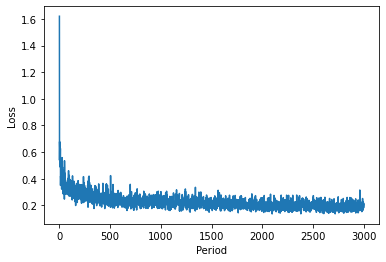

In [13]:
X_df = dataset.loc[:, ['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump',
       'Day of Week', 'day', 'hour', 'month']]
y_df = dataset.loc[:, ['price']]
X = np.array(X_df)
y = np.array(y_df)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


num_features = X.shape[1]
num_periods = len(X) // 10
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(y).reshape((-1, num_periods))
print("X.shape, y.shape:", X.shape, y.shape)

quantiles = [0.1, 0.5, 1]  # 0.1, 0.5, 1
losses, test_mape, test_mae, test_rmse = train(X, y, quantiles)
#print(test_mape, test_mae, test_rmse)


print('====== MAPE, MAE, RMSE ======')
print(sum(test_mape) / len(test_mape),
      sum(test_mae) / len(test_mae), 
      sum(test_rmse) / len(test_rmse))


plt.plot(range(len(losses)), losses)
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()